---
#### Install Requirements

In [77]:
!pip install torchmetrics glob2

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


---
#### Imports

In [4]:
import numpy as np
import glob
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

---
#### Check The Nvidia Graphics is available

In [1]:
!nvidia-smi

Sun Jun  1 22:38:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              2W /  100W |     291MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
#### Load Dataset

In [2]:
def get_dataset(mode: str):
    data_dir = f'./UCI HAR Dataset/{mode}/Inertial Signals/*.txt'
    x_data = []
    for file in glob.glob(data_dir):
        x_data.append(np.loadtxt(file))

    y_data = np.loadtxt(f'./UCI HAR Dataset/{mode}/y_{mode}.txt')

    x = torch.FloatTensor(x_data).permute(1, 2, 0)
    y = torch.LongTensor(y_data) - 1
    return x, y

In [5]:
x_train, y_train = get_dataset('train')

print(x_train.shape, y_train.shape)
print(torch.unique(y_train))  # The -1 in the def is for this line (to class_numbers be from 0 to ...)

torch.Size([7352, 128, 9]) torch.Size([7352])
tensor([0, 1, 2, 3, 4, 5])


C:\Users\Saleh\AppData\Local\Temp\ipykernel_11140\3585128177.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x = torch.FloatTensor(x_data).permute(1, 2, 0)


In [6]:
x_test, y_test = get_dataset('test')

print(x_test.shape, y_test.shape)
print(torch.unique(y_test))  # The -1 in the def is for this line (to class_numbers be from 0 to ...)

torch.Size([2947, 128, 9]) torch.Size([2947])
tensor([0, 1, 2, 3, 4, 5])


---
#### Tensor Dataset

In [7]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

---
#### DataLoader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 128, 9]), torch.Size([64]))

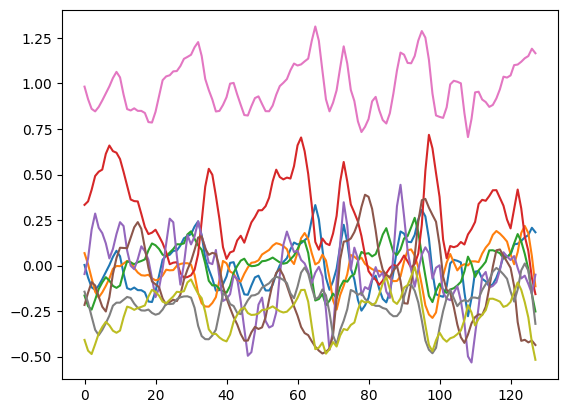

In [120]:
plt.plot(x[0])

---
#### Model (RNN)

##### Custom model

In [27]:
class RNNModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 bidirectional: bool,
                 num_layers: int,
                 nonlinearity: str,
                 bias: bool,
                 batch_first: bool,
                 dropout: float,
                 classes_numbers: int):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          nonlinearity=nonlinearity,
                          bias=bias,
                          batch_first=batch_first,
                          dropout=dropout,
                          bidirectional=bidirectional)
        # hidden_size = hidden_size * 2 if bidirectional else hidden_size
        # self.fc = nn.Linear(hidden_size, classes_numbers)
        self.fc = nn.LazyLinear(classes_numbers)

    def forward(self, x):
        _, hn = self.rnn(x) # outputs, hn
        return self.fc(hn)


In [30]:
model = RNNModel(input_size=9,
                 hidden_size=32,
                 bidirectional=False,
                 num_layers=1,
                 nonlinearity='tanh',
                 bias=True,
                 batch_first=True,
                 dropout=0,
                 classes_numbers=6)
model

RNNModel(
  (rnn): RNN(9, 32, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [29]:
model(x)

tensor([[[-0.0736, -0.1290, -0.0747, -0.2209,  0.1404,  0.2660],
         [-0.0425, -0.0703, -0.0617, -0.2721,  0.2093,  0.3442],
         [-0.0689, -0.1167, -0.0684, -0.2156,  0.1472,  0.2800],
         [-0.0242, -0.0572, -0.0384, -0.2440,  0.1543,  0.3699],
         [-0.0738, -0.1311, -0.0741, -0.2141,  0.1352,  0.2664],
         [-0.1407, -0.2439, -0.1084, -0.2209,  0.1399,  0.2069],
         [-0.0698, -0.1244, -0.0730, -0.2206,  0.1431,  0.2734],
         [-0.1371, -0.1508, -0.0326, -0.2104,  0.1631,  0.2216],
         [-0.2036, -0.1773,  0.0257, -0.1917,  0.1862,  0.2618],
         [-0.2164, -0.2770, -0.0805, -0.3661,  0.2460,  0.2144],
         [-0.0271, -0.1510, -0.1736, -0.2496,  0.1087,  0.2035],
         [-0.0896, -0.1809, -0.1277, -0.2509,  0.1620,  0.2970],
         [-0.0609, -0.0794, -0.0339, -0.2026,  0.1712,  0.3376],
         [-0.0316, -0.0521, -0.0388, -0.1757,  0.1561,  0.3711],
         [-0.0332, -0.1011, -0.1291, -0.2413,  0.1337,  0.3334],
         [-0.0873, -0.147